In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cpu_count = mp.cpu_count()
print(cpu_count)

2


In [ ]:
data_path = "/content/drive/My Drive/traindata/electoral-tagged"
test_path = "/content/drive/My Drive/testdata/electoral-captchas"


In [ ]:
image_fns = os.listdir(data_path)
test_fns = os.listdir(test_path)
print(len(image_fns))
print(np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns]))

940
[5 6]


In [ ]:
for idx, image_fn in enumerate(image_fns):
    if len(image_fn.split(".")[0]) != 5:
           print(idx, image_fn)

42 141931.png
355 424224.png


In [ ]:
image_fns_train, image_fns_test = train_test_split(image_fns, random_state=0)
print(len(image_fns_train), len(image_fns_test))

705 235


In [ ]:
image_ns = [image_fn.split(".")[0] for image_fn in image_fns]
image_ns = "".join(image_ns)
letters = sorted(list(set(list(image_ns))))
print(len(letters))
print(letters)

9
['1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
vocabulary = ["-"] + letters
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

10
['-', '1', '2', '3', '4', '5', '6', '7', '8', '9']
{0: '-', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
{'-': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


In [ ]:
batch_size = 16

In [ ]:
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_dir, image_fns):
        self.data_dir = data_dir
        self.image_fns = image_fns
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [ ]:
trainset = CAPTCHADataset(data_path, image_fns) 
testset = CAPTCHADataset(data_path, image_fns_test)
finaltest = CAPTCHADataset(test_path, test_fns)
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
final_test_loader = DataLoader(finaltest, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
print(len(train_loader), len(test_loader), len(final_test_loader))

59 15 94


In [ ]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([16, 3, 42, 130]) ('63745', '26451', '29432', '31342', '81483', '88218', '63234', '36965', '32315', '11483', '74549', '61595', '61275', '26886', '88419', '51824')


In [ ]:
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 256

10


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
resnet = resnet18(pretrained=True)

In [ ]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(768, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [ ]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('63745', '26451', '29432', '31342', '81483', '88218', '63234', '36965', '32315', '11483', '74549', '61595', '61275', '26886', '88419', '51824')
torch.Size([6, 16, 10])


In [ ]:
criterion = nn.CTCLoss(blank=0)
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss
compute_loss(text_batch, text_batch_logits)

tensor(2.4585, grad_fn=<MeanBackward0>)

In [ ]:
num_epochs = 50
lr = 0.001
weight_decay = 1e-3
clip_norm = 5
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

Epoch:1    Loss:2.450712728500366    NumUpdates:20


Epoch:2    Loss:2.3020426630973816    NumUpdates:12


Epoch:3    Loss:2.2318379481633506    NumUpdates:18


Epoch:4    Loss:2.1496634006500246    NumUpdates:15


Epoch:5    Loss:2.0712837197563867    NumUpdates:22


Epoch:6    Loss:1.9224863052368164    NumUpdates:14


Epoch:7    Loss:1.81913994039808    NumUpdates:21


Epoch:8    Loss:1.7126137390732765    NumUpdates:16


Epoch:9    Loss:1.6210713386535645    NumUpdates:17


Epoch:10    Loss:1.5219561632941752    NumUpdates:17


Epoch:11    Loss:1.4248043715953826    NumUpdates:20


Epoch:12    Loss:1.3724122921625772    NumUpdates:15


Epoch:13    Loss:1.3078906450952803    NumUpdates:14


Epoch:14    Loss:1.2494370698928834    NumUpdates:15


Epoch:15    Loss:1.2312996604225852    NumUpdates:22


Epoch:16    Loss:1.170978558063507    NumUpdates:20


Epoch:17    Loss:1.160198376292274    NumUpdates:21


Epoch:18    Loss:1.087510585784912    NumUpdates:17


Epoch:19    Loss:1.0806527696549892    NumUpdates:16


Epoch:20    Loss:1.0570696592330933    NumUpdates:16


Epoch:21    Loss:1.0447893076472812    NumUpdates:18


Epoch:22    Loss:1.0172101224170012    NumUpdates:17


Epoch:23    Loss:0.9888579437607213    NumUpdates:19


Epoch:24    Loss:0.9900371205239069    NumUpdates:21


Epoch:25    Loss:0.9889446707332835    NumUpdates:17


Epoch:26    Loss:0.9832209173370811    NumUpdates:17


Epoch:27    Loss:0.9439122527837753    NumUpdates:20


Epoch:28    Loss:0.938056543469429    NumUpdates:16


Epoch:29    Loss:0.9313782900571823    NumUpdates:16


Epoch:30    Loss:0.9126063244683402    NumUpdates:14


Epoch:31    Loss:0.8868353577221141    NumUpdates:17


Epoch:32    Loss:0.9159291982650757    NumUpdates:20


Epoch:33    Loss:0.890201735496521    NumUpdates:15


Epoch:34    Loss:0.9126809000968933    NumUpdates:15


Epoch:35    Loss:0.9159464240074158    NumUpdates:16


Epoch:36    Loss:0.8951385742739627    NumUpdates:19


Epoch:37    Loss:0.9112070884023394    NumUpdates:14
Epoch    37: reducing learning rate of group 0 to 1.0000e-04.


Epoch:38    Loss:0.8541884500047435    NumUpdates:23


Epoch:39    Loss:0.7942786054177717    NumUpdates:22


Epoch:40    Loss:0.7791697647836473    NumUpdates:18


Epoch:41    Loss:0.7758168309926987    NumUpdates:20


Epoch:42    Loss:0.762482069787525    NumUpdates:21


Epoch:43    Loss:0.7637797512791373    NumUpdates:22


Epoch:44    Loss:0.7415895074605942    NumUpdates:20


Epoch:45    Loss:0.7570378042402721    NumUpdates:21


Epoch:46    Loss:0.7448665201663971    NumUpdates:22


Epoch:47    Loss:0.7317760437726974    NumUpdates:16


Epoch:48    Loss:0.7417332657745906    NumUpdates:14


Epoch:49    Loss:0.7302360990468193    NumUpdates:17


Epoch:50    Loss:0.7349628323600406    NumUpdates:21



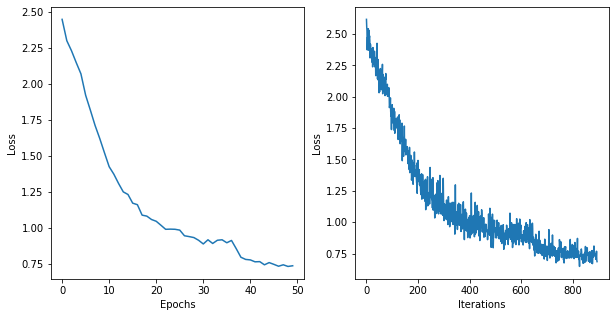

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

In [ ]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [ ]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

In [ ]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

In [ ]:
print(results_train.shape)
results_train.head()

(940, 2)


,actual,prediction
0,11483,114483
1,11482,114882
2,11114,11-114
3,11367,113367
4,11529,115529


In [ ]:
print(results_test.shape)
results_test.head()

(235, 2)


,actual,prediction
0,47936,479936
1,11835,111835
2,75845,758845
3,24353,243353
4,38755,3875-5


In [ ]:
def remove_duplicates(text):
    
    if len(text) > 1:
        #letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
        letters = [text[0]]
        c = 0
        for i in range(1, len(text)):
          if text[i] != text[i-1]:
            letters.append(text[i])
          else:
            c = 1
          if c == 1:
            letters.append(text[i+1:])
            break


    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [ ]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,11483,114483,14483
1,11482,114882,14882
2,11114,11-114,114
3,11367,113367,13367
4,11529,115529,15529


In [ ]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test

,actual,prediction,prediction_corrected
0,47936,479936,47936
1,11835,111835,11835
2,75845,758845,75845
3,24353,243353,24353
4,38755,3875-5,38755
...,...,...,...
230,14746,147446,14746
231,49181,499181,49181
232,25866,258866,25866
233,56175,561775,56175


In [ ]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
44,58945,588445,58445
45,35633,3363-3,3633
46,77774,7--774,774
50,49222,4492-2,4922
55,99519,9-9119,9919
56,97748,977448,97448
61,56232,562222,56222
63,77763,7-7763,7763
65,77654,7-7554,7754
67,99953,9-9533,9953


In [ ]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

4    17
5    16
3     3
Name: prediction_corrected, dtype: int64


In [ ]:
pd.set_option('display.max_rows', 234)
mask = mistakes_df['prediction_corrected'].str.len() == 5
mistakes_df[mask]


,actual,prediction,prediction_corrected
44,58945,588445,58445
56,97748,977448,97448
61,56232,562222,56222
68,99363,999333,99333
73,44719,447119,47119
117,38346,388344,38344
123,89198,899988,89988
129,65525,655555,65555
148,87744,877444,87444
160,88772,877772,87772


/content/drive/My Drive/traindata/electoral-tagged/58945.png


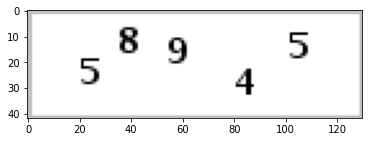

In [ ]:
mistake_image_fp = os.path.join(data_path, mistakes_df[mask]['actual'].values[0] + ".png")
print(mistake_image_fp)
mistake_image = Image.open(mistake_image_fp)
plt.imshow(mistake_image)
plt.show()

In [ ]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.7904255319148936
0.8468085106382979


In [ ]:
finalresults_test = pd.DataFrame(columns=['actual', 'prediction'])
final_test_loader = DataLoader(finaltest, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(final_test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        finalresults_test = pd.concat([finalresults_test, df])
finalresults_test = finalresults_test.reset_index(drop=True)

In [ ]:
print(finalresults_test.shape)
finalresults_test.head()

(1500, 2)


,actual,prediction
0,681,1998-8
1,704,137556
2,66,317743
3,707,933283
4,65,319936


In [ ]:
finalresults_test['prediction_corrected'] = finalresults_test['prediction'].apply(correct_prediction)
finalresults_test.tail()

,actual,prediction,prediction_corrected
1495,675,466331,46331
1496,653,674998,67498
1497,712,688996,68996
1498,683,7-7514,77514
1499,706,297741,29741


In [ ]:
finalresults_test = finalresults_test.sort_values(by=['actual'], kind='mergesort', axis = 0)
finalresults_test

,actual,prediction,prediction_corrected
835,0,6-3372,6372
181,1,215559,21559
848,10,457761,45761
1011,100,571772,57172
498,1000,187773,18773
...,...,...,...
996,995,222788,22788
201,996,772766,72766
191,997,525666,52566
989,998,844591,84591


In [ ]:
finalresults_test.to_csv('finalresults_test.csv')

In [ ]:
from google.colab import files
files.download("finalresults_test.csv")